## RAG as a tool 

In [11]:
import os
import requests
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
##### LLM used #######
from langchain_ollama import ChatOllama 
llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    tempefrature=0.2
)

print(llm.invoke("Hey How are you?"))

content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How about you? How's your day going?" additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2026-01-14T18:29:24.639847Z', 'done': True, 'done_reason': 'stop', 'total_duration': 19206492125, 'load_duration': 3166052042, 'prompt_eval_count': 30, 'prompt_eval_duration': 12549635875, 'eval_count': 50, 'eval_duration': 2447995081, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'} id='lc_run--019bbdc4-bb05-78a0-83e5-69c0fddb3c8a-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 30, 'output_tokens': 50, 'total_tokens': 80}


In [5]:
######### Embedding model ########
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

text = "This is a test document."
query_result = embedding_model.embed_query(text)

# show only the first 100 characters of the stringified vector
print(str(query_result)[:100] + "...")

[-0.0383385606110096, 0.1234646886587143, -0.02864295430481434, 0.05365273356437683, 0.0088453618809...


In [19]:
####### function to upload files and create vectorstore ##########
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
import chromadb

##### function to upload document -> create chunks -> create embedding of each chunk -> stores in vectorDB
def ingest_pdf(pdf_path: str) -> None:
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()
    print(f"Total number of pages in pdf are : {len(docs)}")

    # create chunks 
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
    chunks = text_splitter.split_documents(docs)

    # create vectorstore and add chunks in it 
    try:
        client = chromadb.PersistentClient(path="./chroma_langchain_db")
        vector_store = Chroma(
            client=client,
            collection_name="example_collection",
            embedding_function=embedding_model,
        )
    except Exception as e:
        vector_store = Chroma(
            collection_name="example_collection",
            embedding_function=embedding_model,
            persist_directory="./chroma_langchain_db",
        )

    # add chunks to it 
    vector_store.add_documents(chunks)

    print(f"Documents added successfully to VectorDB")

#### Lets try ingesting a doc

In [10]:
ingest_pdf('./attention_is_al_you_need.pdf')

Total number of pages in pdf are : 15
Documents added successfully to VectorDB


#### Now we can add RAG as a tool in our langgraph flow

In [29]:
from langchain_core.tools import tool 
from langgraph.prebuilt import ToolNode, tools_condition 

from langchain_community.tools import DuckDuckGoSearchRun

#### definin tools #### 
@tool 
def rag_tool(query: str) -> dict:
    """
    RAG is helpful to answer query when data is present in documents uplaoded by user.
    """
    try:
        client = chromadb.PersistentClient(path="./chroma_langchain_db")
        vector_store = Chroma(
            client=client,
            collection_name="example_collection",
            embedding_function=embedding_model,
        )
    except Exception as e:
        {'error' : {e}}
    
    retriever = vector_store.as_retriever(
        search_type="mmr", search_kwargs={"k": 1, "fetch_k": 5}
    )

    chunks_found = retriever.invoke(query)
    context = ""
    for doc in chunks_found:
        context += doc.page_content
    
    return {
        'query' : query,
        'related_docs' : context
    }

############ calculator tool ##############
@tool 
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """ 
    This function does the basic arithematic calculation 'addition' -> '+', 'subtraction' -> '-', multiplication -> '*', division -> '/'
    """
    try:
        if operation == '+':
            result = first_num + second_num 
        elif operation == '-':
            result = first_num - second_num 
        elif operation == '*':
            result = first_num * second_num 
        elif operation == '/':
            if second_num == 0:
                return {'error' : 'Cannot be divisible by zero (0)'}
            else:
                result = round(first_num/second_num, 2)

        return {'first_num' : first_num, 'second_num' : second_num, 'operation' : operation, 'result' : result}
    
    except Exception as e:
        return {'Error' : {e}}


######## Web Search ####################
@tool 
def search_on_web(topic: str) -> dict:
    """Search for information for a given topic on web."""
    search = DuckDuckGoSearchRun()
    result = search.invoke(topic)
    return {'topic': topic, 'result' : result}

######## Get Stock Price ###############
@tool 
def get_stock_price(symbol: str) -> dict:
    """ 
    Fetch latest stock prices for a given symbol (e.g 'AAPL', 'TSLA')
    using Alpha Vantage with API key in URL
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={os.getenv('STOCK_API')}"
    r = requests.get(url)
    return r.json()

In [30]:
tools = [rag_tool, calculator, search_on_web, get_stock_price]
llm_with_tools = llm.bind_tools(tools)

In [31]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated 
from langgraph.checkpoint.memory import InMemorySaver 
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.graph.message import add_messages # Reducer function 

# defining state 
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [32]:
# defining LLM node to chat 
def chat_llm(state: ChatState) -> ChatState:
    """LLM node that may answer or request a tool call."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# tools node 
tool_node = ToolNode(tools)

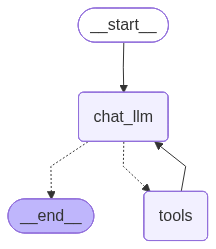

In [33]:
# make a graph 
graph = StateGraph(ChatState)

# define nodes 
graph.add_node("chat_llm", chat_llm)
graph.add_node("tools", tool_node)

# define edges 
graph.add_edge(START, "chat_llm")
graph.add_conditional_edges("chat_llm", tools_condition)
graph.add_edge("tools", "chat_llm")

# compile the graph 
checkpointer = InMemorySaver()
chatbot = graph.compile(checkpointer=checkpointer)

# display the graph 
from IPython.display import Image 
Image(chatbot.get_graph().draw_mermaid_png())

In [34]:
config = {'configurable' : {'thread_id' : "thread-id-5"}}

while True:
    # user will ask a query 
    user_query = input("Type user input : ")
    print(f"User : {user_query}")

    if user_query.strip().lower() in ['end', 'exit', 'bye', 'quit']:
        print("I'm going to end the chat Bye!!")
        break
    
    response = chatbot.stream({'messages' : HumanMessage(content=user_query)}, config=config, stream_mode='messages')

    print("AI : ")
    for chunk, metadata in response:
        print(chunk.content, end="", flush=True)

User : What is attention mechanism in LLMs (from uploaded files)
AI : 
{"query": "attention mechanism in LLMs from uploaded files", "related_docs": "sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-\nwise fully connected feed-forward network. We employ a residual connection [11] around each of\nthe two sub-layers, followed by layer normalization [ 1]. That is, the output of each sub-layer is\nLayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer"}The attention mechanism in Large Language Models (LLMs) from uploaded files plays a crucial role in their architecture. It is a key component that enables the model to focus on specific parts of the input sequence when generating output.

In the context of LLMs, the attention mechanism is often implemented as a multi-head self-attention mechanism. This means that the model attends to different parts of the input sequence simultaneously and weighs their imp